## 0. 라이브러리

In [44]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

## 1. 데이터 불러오기

In [45]:
train_data_path = join('../data', 'htrain.csv')
test_data_path = join('../data', 'htest.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print(train.head(), test.head())

   id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     

## 2. 전처리

### 2.1 변수설정
- train 데이터: unique값인 id제거, 레이블인 price제거
- y 데이터: 키값인 price 할당

In [46]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
y = train['price']

train = train.drop(columns=['id', 'price'])
test = test.drop(columns=['id'])
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 2.2 결측치 확인
- 결측치 없음

In [47]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))
for c in test.columns:
    print('{} : {}'.format(c, len(test.loc[pd.isnull(test[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 2.3-1 데이터 시각화
- 데이터 구조 확인
  - 불균형 변수 확인: 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'

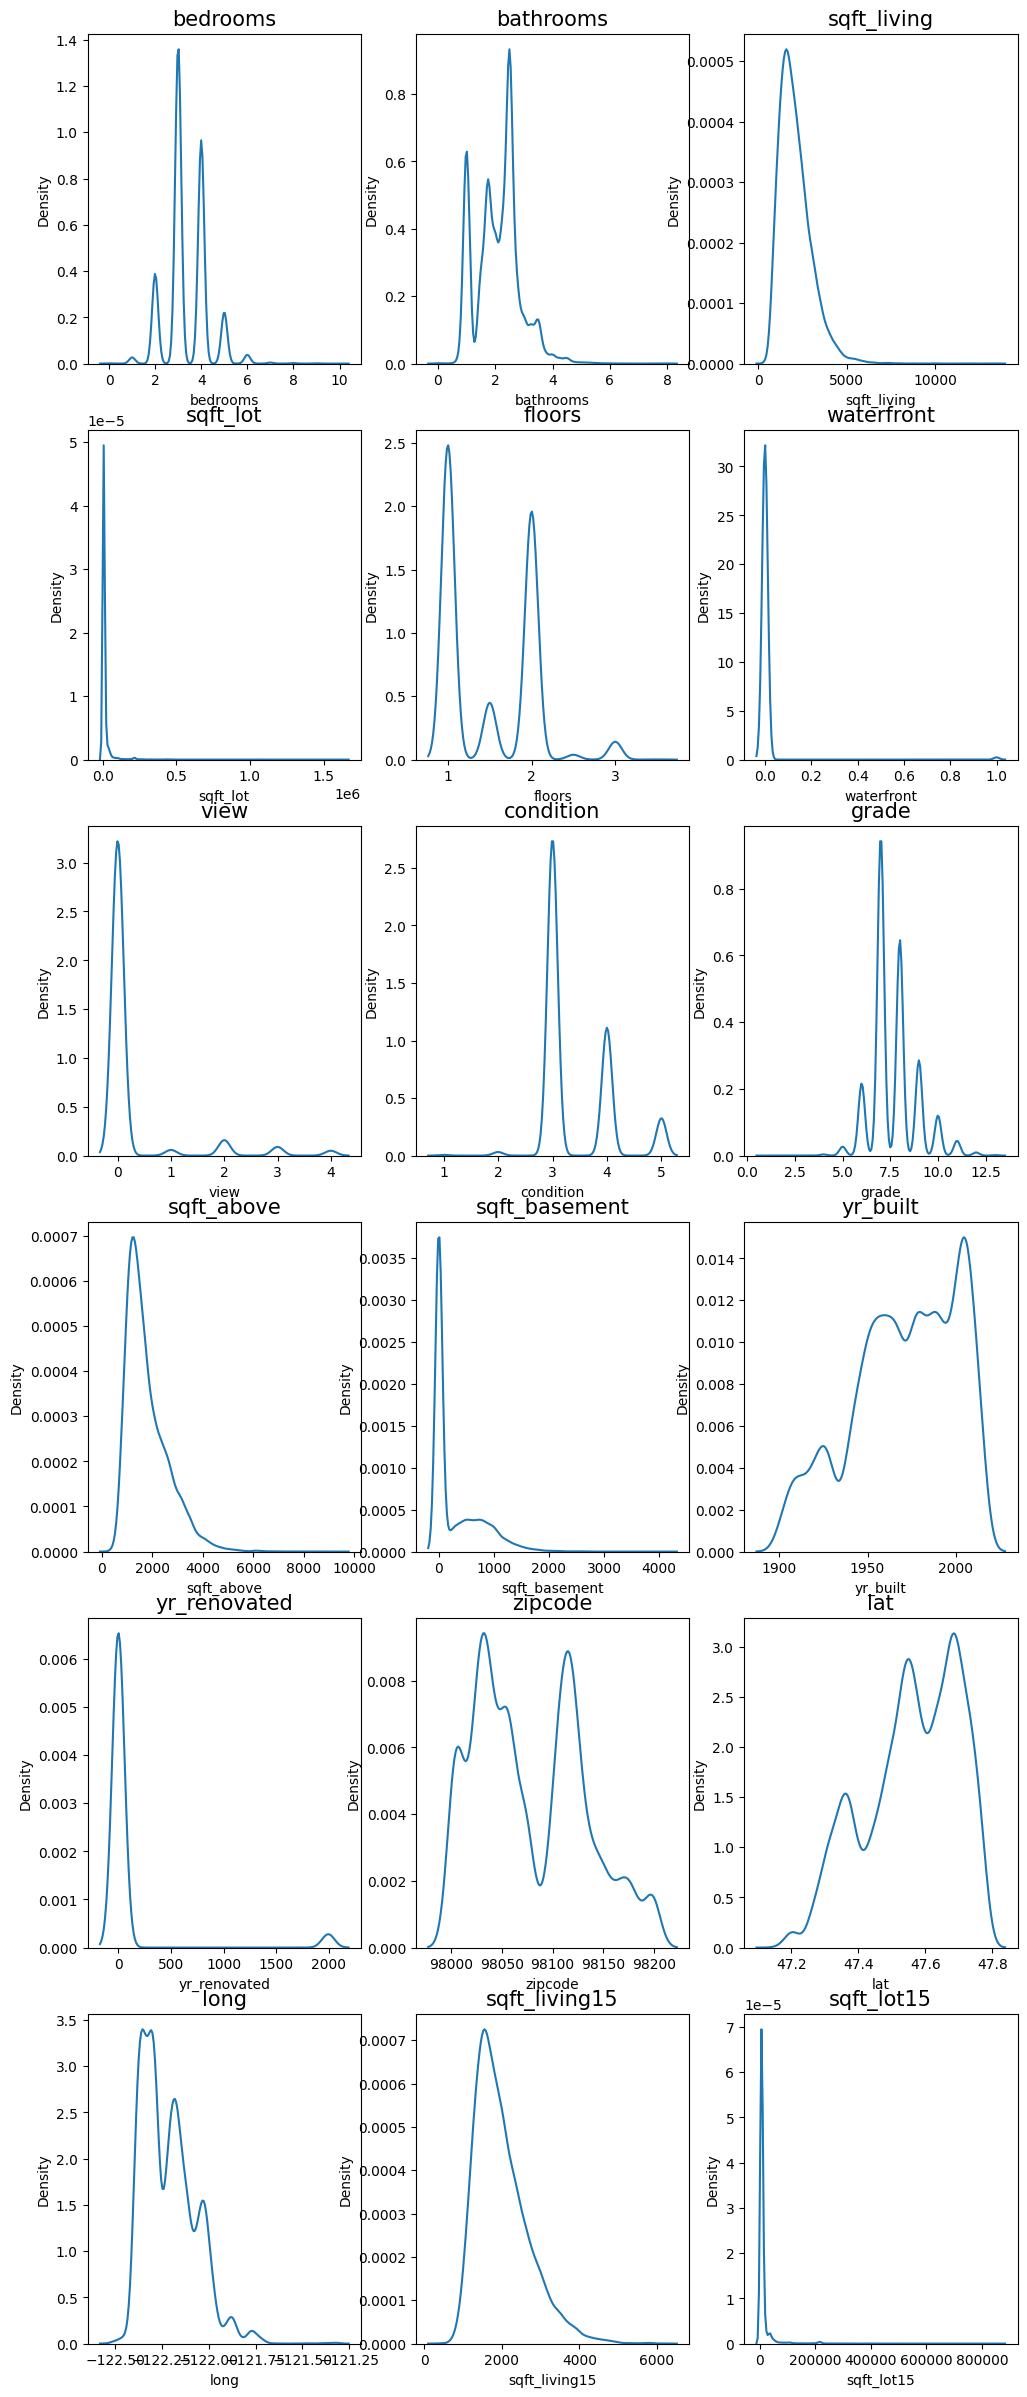

In [48]:
fig, ax = plt.subplots(6, 3, figsize=(12, 30))

count = 1
columns = train.columns
for row in range(6):
    for col in range(3):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

### 2.3-2 불균형 데이터 로그변환

In [49]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
for c in skew_columns:
    train[c] = np.log1p(train[c].values)

### 2.3-3 로그변환 데이터 시각화
- 정규분포의 형태로 변환됨

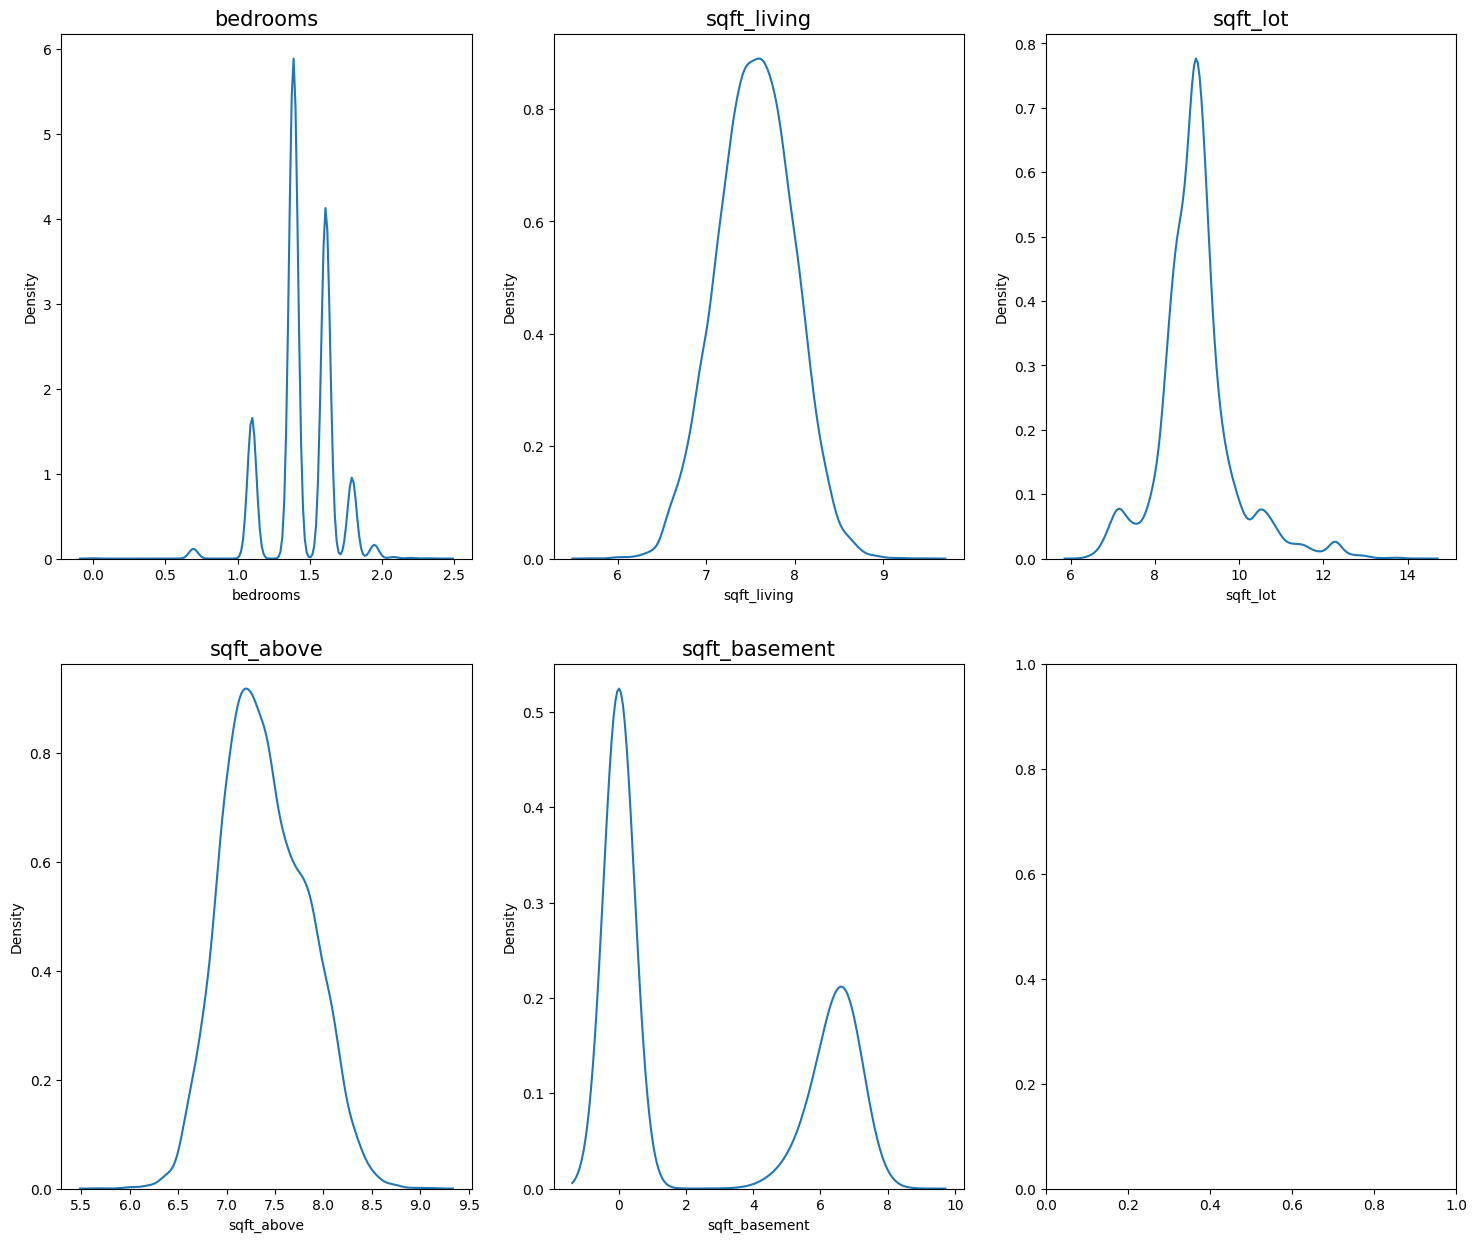

In [50]:
fig, ax = plt.subplots(2, 3, figsize=(18, 15))

count = 0
for row in range(2):
    for col in range(3):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

### 2.4-1 목표변수 시각화

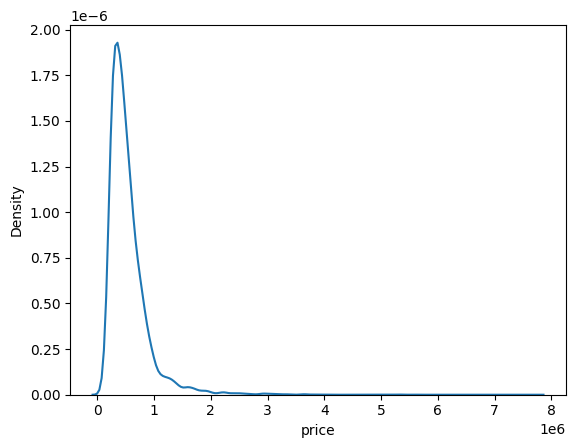

In [51]:
sns.kdeplot(y)
plt.show()

### 2.4-2 목표변수 로그변환, 시각화
- log(x+1)변환 -> expm1( )
- 정규분포의 형태를 띔

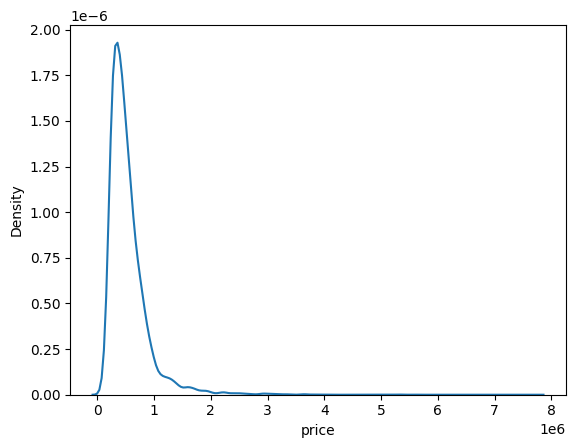

In [52]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

## 3. 모델링

### 3.0 라이브러리

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### 3.1 평가척도 정의
- rmse: 평균제곱오차

In [54]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

### 3.2 모델 정의

In [55]:
random_state=2024

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

### 3.3-1 모델 테스트
- 평가척도 함수 정의

In [56]:

df ={}
def get_scores(models, train, y):
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train test 분리
        x_train, x_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=random_state)
        # 모델학습
        model.fit(x_train.values, y_train)
        # 모델예측
        y_pred =  model.predict(x_val.values)
        # 예츨결과
        rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))
        df[model_name]=rmse
        # dataframe에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df


### 3.3-2 모델 테스트
- 모델별 RMSE 값 비교 : 성능 테스트

In [57]:
get_scores(models, train, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2329
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 539532.511972


,RMSE
LGBMRegressor,160908.606136
XGBRegressor,159119.354664
RandomForestRegressor,153060.944684
GradientBoostingRegressor,152199.497874


## 4. 모델 튜닝

# RdFroest

1. 그리드서치 결과
- max_depth: 10
- min_samples_split: 5
- n_estimators: 200
- RMSLE: 0.18694006444059963

In [15]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(estimator=rdforest, param_grid=param_grid_rf, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search_rf.fit(train, y)

print("Best parameters for RandomForestRegressor:", grid_search_rf.best_params_)
print("Best RMSLE score for RandomForestRegressor:", np.sqrt(-grid_search_rf.best_score_))

# Best parameters for RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
# Best RMSLE score for RandomForestRegressor: 0.18694006444059963

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSLE score for RandomForestRegressor: 0.18694006444059963


2. 그리드서치 결과
- max_depth: 15
- min_samples_split: 3
- n_estimators: 200
- RMSLE: 0.17857462306956384

In [16]:
param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [3, 5, 7]
}
grid_search_rf = GridSearchCV(estimator=rdforest, param_grid=param_grid_rf, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search_rf.fit(train, y)

print("Best parameters for RandomForestRegressor:", grid_search_rf.best_params_)
print("Best RMSLE score for RandomForestRegressor:", np.sqrt(-grid_search_rf.best_score_))

# Best parameters for RandomForestRegressor: {'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 200}
# Best RMSLE score for RandomForestRegressor: 0.17857462306956384

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for RandomForestRegressor: {'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 200}
Best RMSLE score for RandomForestRegressor: 0.17857462306956384


3. 랜덤서치 결과
- max_depth: 15
- min_samples_split: 2 
- n_estimators: 200 
- RMSLE: 0.17841455149291932

In [17]:
param_distributions_rf = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=200, num=10)],
    'max_depth': [int(x) for x in np.linspace(5, 15, num=9)],
    'min_samples_split': [2, 5, 10]
}
random_search_rf = RandomizedSearchCV(estimator=rdforest, param_distributions=param_distributions_rf, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1, n_iter=50, random_state=2024)
random_search_rf.fit(train, y)

print("Best parameters for RandomForestRegressor (RandomizedSearch):", random_search_rf.best_params_)
print("Best RMSLE score for RandomForestRegressor (RandomizedSearch):", np.sqrt(-random_search_rf.best_score_))

# Best parameters for RandomForestRegressor (RandomizedSearch): {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 15}
# Best RMSLE score for RandomForestRegressor (RandomizedSearch): 0.17841455149291932

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for RandomForestRegressor (RandomizedSearch): {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 15}
Best RMSLE score for RandomForestRegressor (RandomizedSearch): 0.17841455149291932


# XGBoost

1. 그리드서치 결과
- learning_rate: 0.1
- max_depth: 5
- n_estimators: 200
- RMSLE: 0.1648540492262775

In [18]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1]
}
grid_search_xgb = GridSearchCV(estimator=xgboost, param_grid=param_grid_xgb, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search_xgb.fit(train, y)

print("Best parameters for XGBRegressor:", grid_search_xgb.best_params_)
print("Best RMSLE score for XGBRegressor:", np.sqrt(-grid_search_xgb.best_score_))

# Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
# Best RMSLE score for XGBRegressor: 0.1648540492262775

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best RMSLE score for XGBRegressor: 0.1648540492262775


2. 그리드서치 결과
- learning_rate: 0.1
- max_depth: 5
- n_estimators: 250
- RMSLE: 0.1638336356583381

In [19]:
param_grid_xgb = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}
grid_search_xgb = GridSearchCV(estimator=xgboost, param_grid=param_grid_xgb, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search_xgb.fit(train, y)

print("Best parameters for XGBRegressor:", grid_search_xgb.best_params_)
print("Best RMSLE score for XGBRegressor:", np.sqrt(-grid_search_xgb.best_score_))

# Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
# Best RMSLE score for XGBRegressor: 0.1638336356583381

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
Best RMSLE score for XGBRegressor: 0.1638336356583381


3. 그리드서치 결과
- learning_rate: 0.1
- max_depth: 6
- n_estimators: 200
- RMSLE: 0.16365790051646736

In [20]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.15]
}
grid_search_xgb = GridSearchCV(estimator=xgboost, param_grid=param_grid_xgb, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search_xgb.fit(train, y)

print("Best parameters for XGBRegressor:", grid_search_xgb.best_params_)
print("Best RMSLE score for XGBRegressor:", np.sqrt(-grid_search_xgb.best_score_))

# Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
# Best RMSLE score for XGBRegressor: 0.16365790051646736

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best RMSLE score for XGBRegressor: 0.16365790051646736


4. 랜덤서치 결과
- learning_rate: 0.15
- max_depth: 6
- n_estimators: 166
- RMSLE: 0.16393211721345755

In [21]:
param_distributions_xgb = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=200, num=10)],
    'max_depth': [int(x) for x in np.linspace(3, 10, num=8)],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2]
}
random_search_xgb = RandomizedSearchCV(estimator=xgboost, param_distributions=param_distributions_xgb, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1, n_iter=50, random_state=2024)
random_search_xgb.fit(train, y)

print("Best parameters for XGBRegressor (RandomizedSearch):", random_search_xgb.best_params_)
print("Best RMSLE score for XGBRegressor (RandomizedSearch):", np.sqrt(-random_search_xgb.best_score_))

# Best parameters for XGBRegressor (RandomizedSearch): {'n_estimators': 166, 'max_depth': 6, 'learning_rate': 0.15}
# Best RMSLE score for XGBRegressor (RandomizedSearch): 0.16393211721345755

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for XGBRegressor (RandomizedSearch): {'n_estimators': 166, 'max_depth': 6, 'learning_rate': 0.15}
Best RMSLE score for XGBRegressor (RandomizedSearch): 0.16393211721345755


# LGBM

1. 그리드서치 결과
- learning_rate: 0.1
- max_depth: 10
- n_estimators: 200
- RMSLE: 0.16182233445810507

In [22]:
param_grid_lgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1]
}
grid_search_lgb = GridSearchCV(estimator=lightgbm, param_grid=param_grid_lgb, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search_lgb.fit(train, y)

print("Best parameters for LGBMRegressor:", grid_search_lgb.best_params_)
print("Best RMSLE score for LGBMRegressor:", np.sqrt(-grid_search_lgb.best_score_))

# Best parameters for LGBMRegressor: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
# Best RMSLE score for LGBMRegressor: 0.16182233445810507

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for LGBMRegressor: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Best RMSLE score for LGBMRegressor: 0.16182233445810507


2. 그리드서치 결과
- learning_rate: 0.1
- max_depth: 10
- n_estimators: 200
- RMSLE: 0.16182233445810507

In [23]:
param_grid_lgb = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.15]
}
grid_search_lgb = GridSearchCV(estimator=lightgbm, param_grid=param_grid_lgb, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search_lgb.fit(train, y)

print("Best parameters for LGBMRegressor:", grid_search_lgb.best_params_)
print("Best RMSLE score for LGBMRegressor:", np.sqrt(-grid_search_lgb.best_score_))

# Best parameters for LGBMRegressor: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
# Best RMSLE score for LGBMRegressor: 0.16182233445810507

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters for LGBMRegressor: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Best RMSLE score for LGBMRegressor: 0.16182233445810507


3. 랜덤서치 결과
- learning_rate: 0.1
- max_depth: 12
- n_estimators: 183
- RMSLE: 0.16243262328844493

In [24]:
param_distributions_lgb = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=200, num=10)],
    'max_depth': [int(x) for x in np.linspace(5, 15, num=9)],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2]
}
random_search_lgb = RandomizedSearchCV(estimator=lightgbm, param_distributions=param_distributions_lgb, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1, n_iter=50, random_state=2024)
random_search_lgb.fit(train, y)

print("Best parameters for LGBMRegressor (RandomizedSearch):", random_search_lgb.best_params_)
print("Best RMSLE score for LGBMRegressor (RandomizedSearch):", np.sqrt(-random_search_lgb.best_score_))

# Best parameters for LGBMRegressor (RandomizedSearch): {'n_estimators': 183, 'max_depth': 12, 'learning_rate': 0.1}
# Best RMSLE score for LGBMRegressor (RandomizedSearch): 0.16243262328844493

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122
Best parameters for LGBMRegressor (RandomizedSearch): {'n_estimators': 183, 'max_depth': 12, 'learning_rate': 0.1}
Best RMSLE score for LGBMRegressor (RandomizedSearch): 0.16243262328844493


## 5. 튜닝 모델 비교
- RF
  - max_depth: 15
  - min_samples_split: 2 
  - n_estimators: 200 
  - RMSLE: 0.17841455149291932
- XGB
  - learning_rate: 0.1
  - max_depth: 6
  - n_estimators: 200
  - RMSLE: 0.16365790051646736
- LGBM
  - learning_rate: 0.1
  - max_depth: 10
  - n_estimators: 200
  - RMSLE: 0.16182233445810507

### 5.1 튜닝 모델 정의

In [58]:
rf = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=2, random_state=random_state)
xgb = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=random_state)
lgb = LGBMRegressor(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=random_state)

### 5.2 비교

In [59]:
data = {
    "Model": ["RF", "XGB", "LGBM"],
    "max_depth": [15, 6, 10],
    "min_samples_split": [2, None, None],
    "n_estimators": [200, 200, 200],
    "learning_rate": [None, 0.1, 0.1],
    "RMSLE": [0.17841455149291932, 0.16365790051646736, 0.16182233445810507]
}
df = pd.DataFrame(data)
df

,Model,max_depth,min_samples_split,n_estimators,learning_rate,RMSLE
0,RF,15,2.0,200,NaN,0.178415
1,XGB,6,NaN,200,0.1,0.163658
2,LGBM,10,NaN,200,0.1,0.161822


## 6. 앙상블
- Voting Ensemble
- Soft Voting: 평균 계산

In [63]:
from sklearn.ensemble import VotingRegressor

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

# 모델 정의
voting_regressor = VotingRegressor(estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb)])
# 모델 학습
voting_regressor.fit(train, y)
# 예측
y_pred = voting_regressor.predict(test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 540682.653143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

In [29]:
# 결과
y_pred = np.expm1(y_pred)
y_pred 

array([ 677812.85572008,  671513.88104074, 1658582.21781502, ...,
       1116710.29852826,  780629.73860207,  912281.16917611])

In [ ]:
submission_path = join('../data', 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = y_pred

In [ ]:
submission.to_csv('submission.csv', index=False)

### 회고
- 다양한 모델의 성능 차이에 대해 알아볼 수 있었다.
- 각 모델의 최적의 하이퍼 파라미터를 튜닝해 볼 수 있었고,
- 최종적으로 모델을 앙상블 하여 모델간 평균으로 투표 해보았다.
- num_leaves나 boosting_type을 튜닝해보지 못한점이 아쉬웠다.
- 생각보다 최종 예측 결과가 좋지 못해 아쉬웠다.